# DATA DOWNLOAD
To start this project, you need an addition data file.

First you should download data from:
https://pan.baidu.com/s/1KFui9zZKjRqzFkCJH5nenw
    
Then unzip it,create a data dir, and put it in data directory

## After you do all that , the following file should be found:

```python
'data/segmented_train_seg_by_word.txt' 
```

And that means you are good to go.

In [50]:
! wc -l data/segmented_train_seg_by_word.txt

20000000 data/segmented_train_seg_by_word.txt


# DATA PROCESS

In [2]:
from utils import ProgressBar
import numpy as np
import collections
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
enline = None
chline = None

sentlength = np.inf

enlines = []
chlines = []
pb = ProgressBar(worksum=10000000)
pb.startjob()
num = 0
with open('data/segmented_train_seg_by_word.txt') as fhdl:
    for line in fhdl:
        num += 1
        if num % 2 == 1:
            enline = line
            continue
        else:
            chline = line
        
        enlinesp = [i.lower() for i in enline.strip("\n").split()]
        chlinesp = [i for i in chline.strip("\n").split()]
        if len(enlinesp) <= sentlength and len(chlinesp) <= sentlength:
            enlines.append(enlinesp)
            chlines.append(chlinesp)
        if (num // 2) % 1000 == 0:
            pb.complete(1000)
            
        #if num // 2 >= 1000000:
        #    break
        

 100.00 % [==================================================>] 10000000/10000000 	 used:121s eta:0 s

In [ ]:
enlines[:10]

In [ ]:
chlines[:10]

In [8]:
len(chlines),len(enlines)

(10000000, 10000000)

In [5]:
chwords = []

for sent in chlines:
    for chword in sent:
        chwords.append(chword)

In [6]:
from collections import Counter

In [7]:
Counter(chwords).most_common(15)

[('。', 7829572),
 ('的', 5689326),
 ('，', 5226407),
 ('我', 3454986),
 ('你', 2687663),
 ('了', 2071109),
 ('？', 1571009),
 ('是', 1485247),
 ('在', 1418398),
 ('他', 1118269),
 ('我们', 899295),
 ('和', 644347),
 ('她', 633832),
 ('不', 627412),
 ('就', 545092)]

In [9]:
def addchar(what2ind,ind2what,char):
    if char in what2ind:
        return 
    ind2what[len(what2ind)] = char
    what2ind[char] = len(what2ind)

In [10]:
ch2ind = {}
ind2ch = {}

specialchars = ['<pad>','<unk>']

for one in specialchars:
    addchar(ch2ind,ind2ch,one)

In [11]:
for word,_ in Counter(chwords).most_common(10000):
    addchar(ch2ind,ind2ch,word)

In [12]:
dat_x_in = []

for chsent in chlines:
    indsent = [ch2ind.get(i,ch2ind['<unk>']) for i in chsent]
    #indsent.append(ch2ind['<eos>'])
    dat_x_in += indsent


In [13]:
print(''.join([ind2ch[i] for i in dat_x_in[:20]]))

一对<unk>正监视着它们的<unk>领地一对<unk>飞到我们屋顶上的<unk>，它们


In [14]:
len(dat_x_in)

109497518

In [15]:
def data_generator(batch_size,cbow):
    'cbow<--|word|-->cbow'
    window = 2 * cbow + 1
    batch_data = []
    
    while True:
        for i in range(len(dat_x_in) - window):
            batch_data.append(dat_x_in[i:i + window])
            if len(batch_data) >= batch_size:
                batch_data = np.asarray(batch_data)
                batch_x = np.concatenate([batch_data[:,:cbow],batch_data[:,-cbow:]],axis=1)
                batch_y = batch_data[:,cbow]
                yield batch_x,batch_y
                batch_data = []

In [16]:
gen = data_generator(128,1)

In [17]:
batch_x,batch_y = gen.__next__()

In [18]:
batch_x.shape ,batch_y.shape

((128, 2), (128,))

# MODEL PART

In [19]:
batch_size = 256
embedding_size = 100
vocabulary_size = len(ind2ch)
cbow = 1
negative_sample_number = 64

In [20]:
import tensorflow as tf
import tflearn
tf.reset_default_graph()
config = tf.ConfigProto(log_device_placement=True,allow_soft_placement = True)
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)


/usr/local/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [21]:

tf.reset_default_graph()
config = tf.ConfigProto(log_device_placement=True,allow_soft_placement = True)
config.gpu_options.allow_growth = True
session = tf.Session(config=config)


with tf.device('/gpu:1'):
    x = tf.placeholder(tf.int32, shape=[None,2 * cbow])
    y = tf.placeholder(tf.int32, shape=[None])
    target = tf.expand_dims(y,1)
    learning_rate = tf.placeholder(tf.float32)

    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -0.08, 0.08))
    
    sample_x =  tf.placeholder(tf.int32, shape=[None])
    sample_embedding = tf.nn.embedding_lookup(embeddings, sample_x)
    
    nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                     stddev=1.0 / np.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    one_embedding = None
    for i in range(2 * cbow):
        if one_embedding is None:
            one_embedding = tf.nn.embedding_lookup(embeddings, x[:,i])
        else:
            one_embedding += tf.nn.embedding_lookup(embeddings, x[:,i])
    avg_embedding = one_embedding / (2 * cbow)
    
    nce_loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases,
                               labels=target,
                               inputs=avg_embedding,
                               num_sampled=negative_sample_number,
                               num_classes=len(ind2ch)))
    
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(nce_loss)

In [25]:
saver = tf.train.Saver()
saver.restore(session,'./models/word2vec_model')

INFO:tensorflow:Restoring parameters from ./models/word2vec_model


In [60]:
session.run(tf.global_variables_initializer())

In [61]:
session.run(sample_embedding,feed_dict={
    sample_x:batch_y
}).shape

(256, 100)

In [62]:
cbow

1

In [63]:
losses = []
beginning_lr = 0.1
gen = data_generator(batch_size,cbow)
for one_epoch in range(1,5):
    pb = ProgressBar(worksum=len(dat_x_in))
    pb.startjob()
    for one_batch in range(len(dat_x_in) // batch_size):
        batch_x,batch_y = gen.__next__()
        batch_lr = beginning_lr 
        _,batch_loss = session.run([optimizer,nce_loss],feed_dict={
            x:batch_x,
            y:batch_y,
            learning_rate:batch_lr,
        })
        pb.info = "EPOCH {} batch {} lr {} loss {}".format(one_epoch,one_batch,batch_lr,batch_loss)
        pb.complete(batch_size)
        losses.append(batch_loss)
    print()

EPOCH 1 batch 427723 lr 0.1 loss 3.867262840270996 100.00 % [=================================================>-] 109497344/109497518 	 used:1669s eta:0 sss
EPOCH 2 batch 427723 lr 0.1 loss 3.7717745304107666 100.00 % [=================================================>-] 109497344/109497518 	 used:1669s eta:0 ss
EPOCH 3 batch 427723 lr 0.1 loss 3.847435474395752 100.00 % [=================================================>-] 109497344/109497518 	 used:1670s eta:0 sss
EPOCH 4 batch 427723 lr 0.1 loss 3.876709461212158 100.00 % [=================================================>-] 109497344/109497518 	 used:1677s eta:0 sss


In [72]:
batch_x.shape,batch_y.shape

((256, 2), (256,))

In [26]:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm

In [27]:
word = '海洋'

In [28]:
inputx = ch2ind[word]

In [29]:
embedding_val = session.run(sample_embedding,feed_dict={sample_x:[inputx]})

In [30]:
dis_words = np.matmul(embedding_val,np.transpose(session.run(normalized_embeddings)))

In [31]:
dis_words

array([[0.72659206, 3.0300503 , 2.2285578 , ..., 3.564032  , 3.3758368 ,
        3.7083294 ]], dtype=float32)

In [32]:
[ind2ch[i] for i in np.argsort(dis_words[0])[::-1][:8]]

['海洋', '海湾', '森林', '土壤', '沙漠', '文学', '大气', '野生动物']

In [ ]:
import pandas as pd
%matplotlib inline
pd.DataFrame(losses[:100000]).plot()

In [97]:
saver = tf.train.Saver()

In [98]:
saver.save(session,'models/word2vec_model')

'models/word2vec_model'

In [99]:
! ls -l 'models/word2vec_model.data-00000-of-00001'

-rw-rw-r-- 1 meta meta 16083216  7月  6 08:46 models/word2vec_model.data-00000-of-00001


# 可视化

In [42]:
words_embedding = session.run(embeddings)

In [43]:
from sklearn.decomposition import PCA

In [44]:
pca = PCA(n_components=2, svd_solver='full')

In [45]:
words_embedding_pca = pca.fit_transform(words_embedding)

In [46]:
import pypinyin
#zhfont1 = matplotlib.font_manager.FontProperties(fname='/usr/share/fonts/cjkunifonts-ukai/ukai.ttc')
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']
 
decisionNode = dict(boxstyle = "sawtooth", fc = "0.8")
leafNode = dict(boxstyle = "round4", fc = "0.8")
arrow_args = dict(arrowstyle = "<-")

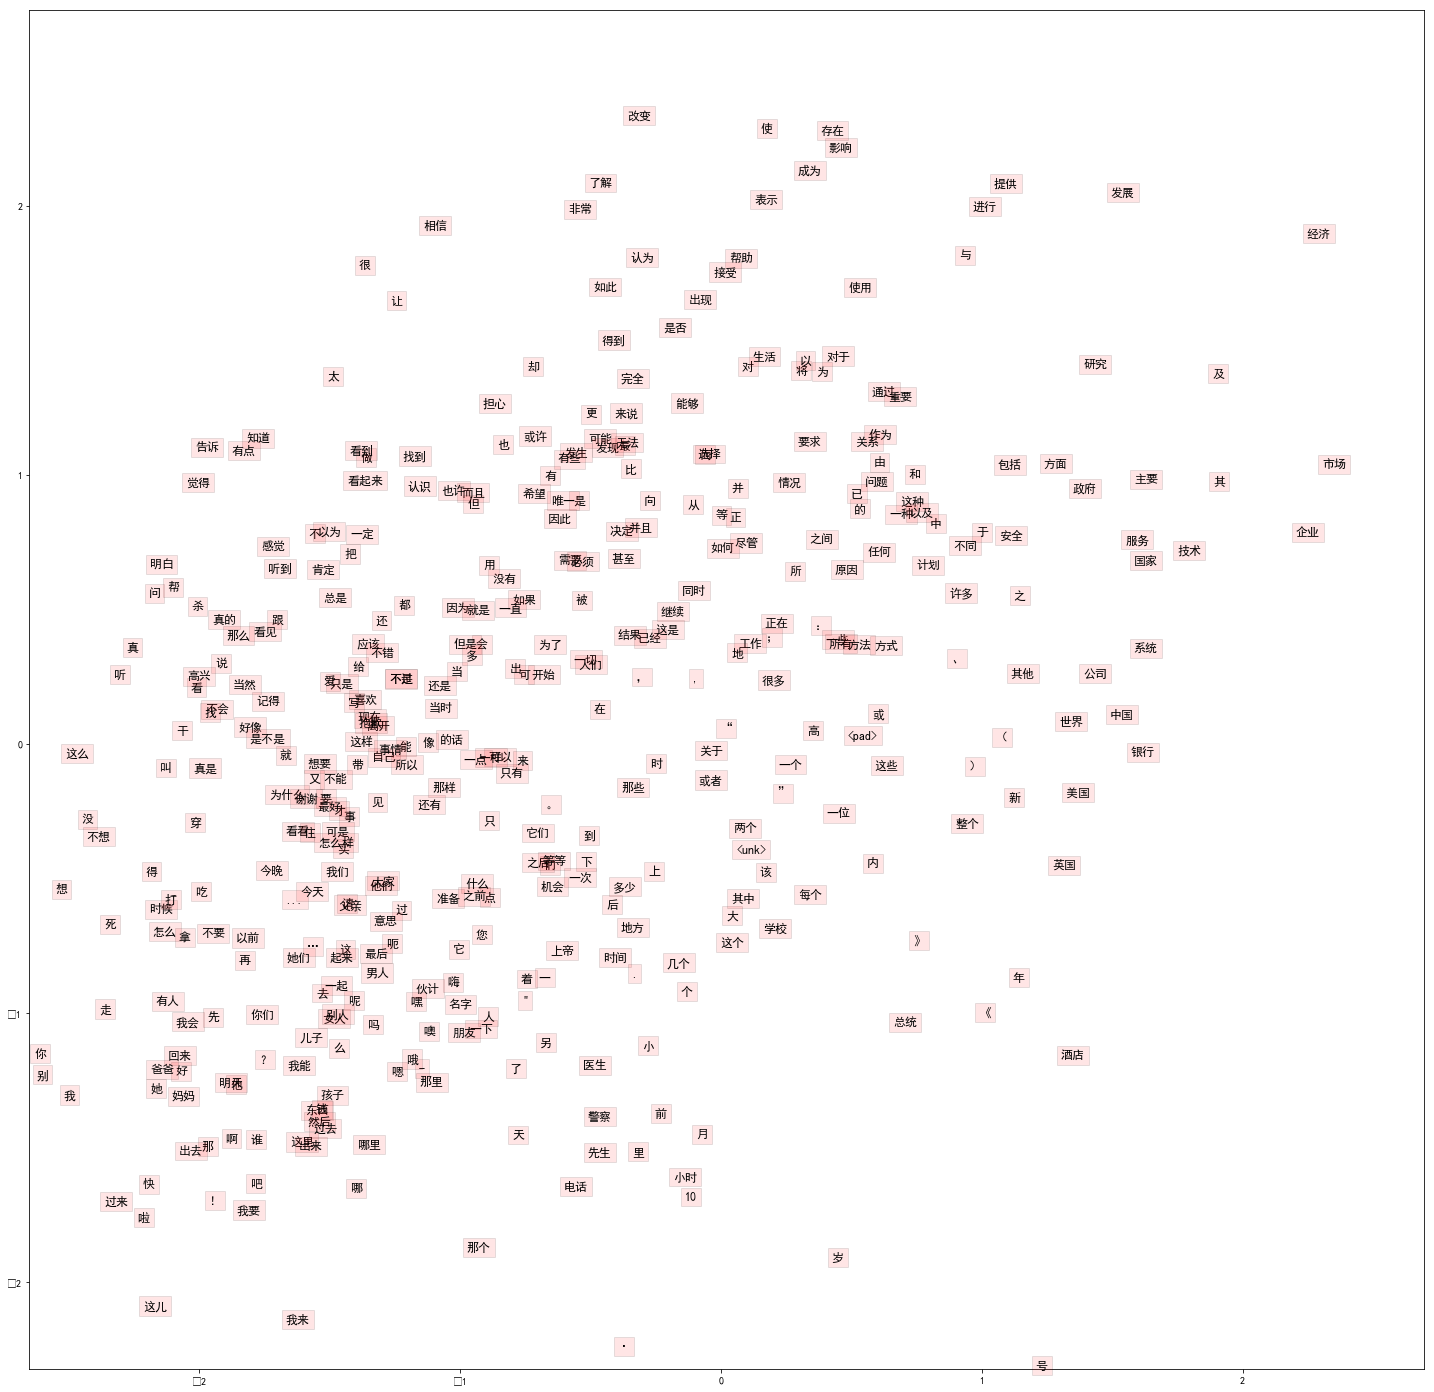

In [52]:
plt.figure(figsize=(25,25))
#'_'.join(pypinyin.lazy_pinyin(ind2ch[i]))
for i in range(400):
    coord = words_embedding_pca
    color = 'red'
    plt.text(coord[i, 0], coord[i, 1],ind2ch[i], bbox=dict(facecolor=color, alpha=0.1),
             fontsize=12)  # fontproperties = ChineseFont1
plt.xlim((np.min(coord[:, 0]), np.max(coord[:, 0])))
plt.ylim((np.min(coord[:, 1]), np.max(coord[:, 1])))
plt.show()